

# Project: The King -- Zlatan Ibrahimovic

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


For this analysis I selected football dataset. This comes with 8 tables
and it requires SQL skills to fetch the data and connect it with pandas.

In this study I mainly want to focus on Zlatan Ibrahimovic and how does
he change the teams that he played. He is a very well known striker who played for 4 different teams in the time span of this data we have.

In [14]:
#  Import Statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import scipy.stats
import matplotlib
%matplotlib inline
import seaborn as sns
from pandas import Series, DataFrame, Panel

import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect("database.sqlite")

<a id='wrangling'></a>
## Data Wrangling

Zlatan Ibrahimovich played in 4 teams during the period that we have the data of. These are Inter, Barcelona, Milan and PSG. So I need match data of these 4 teams.

### General Properties

First we need to connect to the database and convert tables into Pandas dataframes.

In [15]:
players = pd.read_sql_query("select * from Player;", conn)
player_attributes = pd.read_sql_query("select * from Player_Attributes;", conn)
matches = pd.read_sql_query("select * from Match;", conn)
countries = pd.read_sql_query("select * from Country;", conn)
leagues = pd.read_sql_query("select * from League;", conn)
teams = pd.read_sql_query("select * from Team;", conn)
team_attributes = pd.read_sql_query("select * from Team_Attributes;", conn)

In [16]:
#  We need to locate zlatan in players dataframe
zlatan = players[players.player_name == 'Zlatan Ibrahimovic']
zlatan

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
11041,11057,35724,Zlatan Ibrahimovic,41236,1981-10-03 00:00:00,195.58,209


Investigating this data, we can see Zlatan is 36 years old, at the time of this analysis, and he is quite tall for a footballer. Also from here we can locate his player id and fifa player id. Next we need to use that information!

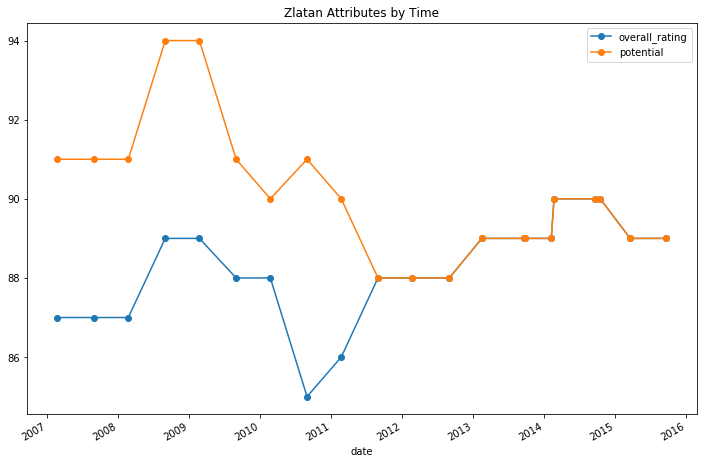

In [17]:
%%capture --no-display
zlatan_attribs = player_attributes[player_attributes.player_fifa_api_id == 41236]
zlatan_attribs['date'] = pd.to_datetime(zlatan_attribs.date)

zlatan_attribs.plot(y=['overall_rating','potential'], x='date', figsize=(12,8),marker='o', title='Zlatan Attributes by Time')



Looking the chart we can conclude Zlatan is one of the best footballers. First we should define a function to retrieve all the games Zlatan played according to the seasons so that we can make analysis later.

In [18]:
team_ids_of_zlatan = [9847, 8636, 8564, 8634]

teams_of_zlatan = teams[teams.team_api_id.isin(team_ids_of_zlatan)]


In [19]:
#  These 2 functions returns a dataframe that includes home games and  
#  away games of player.
    
def find_all_home_games_of_a_player(player_id):
    home_matches = pd.DataFrame()
    home_matches = matches[matches.home_player_1 == player_id]
    home_matches = home_matches.append(matches[matches.home_player_2 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_3 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_4 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_5 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_6 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_7 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_8 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_9 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_10 == player_id])
    home_matches = home_matches.append(matches[matches.home_player_11 == player_id])
    
    return home_matches

def find_all_away_games_of_a_player(player_id):
    away_matches = pd.DataFrame()
    away_matches = matches[matches.away_player_1 == player_id]
    away_matches = away_matches.append(matches[matches.away_player_2 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_3 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_4 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_5 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_6 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_7 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_8 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_9 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_10 == player_id])
    away_matches = away_matches.append(matches[matches.away_player_11 == player_id])
    
    return away_matches

In the later stages we will also need functions to find the games of a
team that Zlatan played for a season.

In [20]:
# Here I define a function to find all games of a team

def home_games_of_a_team(team_id, df):
    home_games = df[df.home_team_api_id == (team_id)]
    return home_games

def away_games_of_a_team(team_id, df):
    away_games = df[df.away_team_api_id == (team_id)]
    return away_games

def all_games_of_a_team(team_id, df):
    #home games
    all_games = pd.DataFrame()
    
    all_games = all_games.append(home_games_of_a_team(team_id, df))
    #  away games
    all_games = all_games.append(away_games_of_a_team(team_id, df))
    
    return all_games


In [21]:
#  This function finds out the matches of a team in a season
#

def find_team_season(team_id, season, isHome):
    result_df = pd.DataFrame()
    if isHome:
        result_df = home_games_of_a_team(team_id, matches)
    else:
        result_df = away_games_of_a_team(team_id, matches)
        
    result_df = result_df[result_df.season == season]
    return result_df

We will also need a function to find the wins in the dataframe

In [22]:
# Finds the wins of a team in a dataframe it can work for home games
# and away games

def find_home_wins(df, isHome):
    results = pd.DataFrame(columns=['win', 'draw', 'loss'])
    win = 0
    draw = 0
    loss = 0
    
    if isHome:
        for index, row in df.iterrows():
            if(row.home_team_goal>row.away_team_goal):
                win +=1
            elif(row.home_team_goal==row.away_team_goal):
                draw +=1
            else:
                loss +=1
    else:
        for index, row in df.iterrows():
            if(row.home_team_goal>row.away_team_goal):
                loss +=1
            elif(row.home_team_goal==row.away_team_goal):
                draw +=1
            else:
                win +=1

    results.loc[0] = [win, draw, loss]
    return results.loc[0]


<a id='eda'></a>
## Exploratory Data Analysis

We now have 2 research questions related with Zlatan Ibrahimovic first one is about win rates of the teams that Zlatan played in the games with him or without him, second one is this time about the goals scored in the games.

### Research Question 1 Do the teams of Zlatan win more games when he plays compared to the matches they play without him?

So we start with this question about winning rates of the teams. Since he is a very good player we are expecting the winning rate to be higher for all the teams he played. To conclude he is a game changer.

Limitations of this study is that we dont know if Zlatan Ibrahimovic appeared as a sub! This is not included in the data set. Or I couldnt find enough information about it.

I will create a function to make this analysis easier.

In [23]:
#  This function analyzes win rates of a team with the player that we are
#  checking and it returns a result dataframe

def analyze_a_season_of_a_player(season, player_id, team_id):
    
    result = pd.DataFrame(columns=['season','home_matches_w_player', 'home_wins_w_player', 'home_win_rate_w_player', \
                                  'home_matches_wo_player', 'home_wins_wo_player', 'home_win_rate_wo_player',\
                                  'away_matches_w_player', 'away_wins_w_player', 'away_win_rate_w_player',\
                                  'away_matches_wo_player', 'away_wins_wo_player', 'away_win_rate_wo_player',])
    
    # matches of the player
    home_games = find_all_home_games_of_a_player(player_id)
    home_games_season = home_games[home_games.season == season]
    home_games_team = find_team_season(team_id, season, True)

    home_game_count_player = home_games_season.id.count()
    home_game_win_count_player = find_home_wins(home_games_season, True).win
    home_game_win_rate_player = home_game_win_count_player / home_game_count_player
    home_game_count_team = home_games_team.id.count()
    home_game_win_count_team = find_home_wins(home_games_team, True).win
    home_game_win_rate_team = home_game_win_count_team / home_game_count_team
    
    df = pd.merge(home_games_team, home_games_season, how='outer', indicator=True)
    rows_in_df1_not_in_df2 = df[df['_merge']=='left_only'][home_games_team.columns]

    home_game_count_wo_player = rows_in_df1_not_in_df2.id.count()
    home_game_win_count_wo_player = find_home_wins(rows_in_df1_not_in_df2, True).win
    home_game_win_rate_wo_player = home_game_win_count_wo_player / home_game_count_wo_player
    
    
    away_games = find_all_away_games_of_a_player(player_id)
    away_games_season = away_games[away_games.season == season]
    away_games_team = find_team_season(team_id, season, False)
    
    away_game_count_player = away_games_season.id.count()
    away_game_win_count_player = find_home_wins(away_games_season, False).win
    away_game_win_rate_player = away_game_win_count_player / away_game_count_player
    away_game_count_team = away_games_team.id.count()
    away_game_win_count_team = find_home_wins(away_games_team, False).win
    away_game_win_rate_team = away_game_win_count_team / away_game_count_team

    df = pd.merge(home_games_team, home_games_season, how='outer', indicator=True)
    rows_in_df1_not_in_df2 = df[df['_merge']=='left_only'][home_games_team.columns]

    away_game_count_wo_player = rows_in_df1_not_in_df2.id.count()
    away_game_win_count_wo_player = find_home_wins(rows_in_df1_not_in_df2, False).win
    away_game_win_rate_wo_player = away_game_win_count_wo_player / away_game_count_wo_player
   
    
    result.loc[0] = [season, home_game_count_player, home_game_win_count_player, \
                    home_game_win_rate_player, home_game_count_wo_player, \
                    home_game_win_count_wo_player, home_game_win_rate_wo_player, \
                    away_game_count_player, away_game_win_count_player, \
                    away_game_win_rate_player, away_game_count_wo_player, \
                    away_game_win_count_wo_player, away_game_win_rate_wo_player, \
                    ]
    return result


We know the teams and respective season Zlatan played in this team. We will create a DataFrame with this data to see the overall performance of Zlatan.

In [24]:
%%capture --no-display

seasons_of_zlatan = pd.DataFrame()
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2008/2009', 35724, 8636))
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2009/2010', 35724, 8634))
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2010/2011', 35724, 8664))
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2011/2012', 35724, 8564))
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2012/2013', 35724, 9847))
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2013/2014', 35724, 9847))
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2014/2015', 35724, 9847))
seasons_of_zlatan = seasons_of_zlatan.append(analyze_a_season_of_a_player('2015/2016', 35724, 9847))

And with this data on hand we will create a plot to see how Zlatan performed.

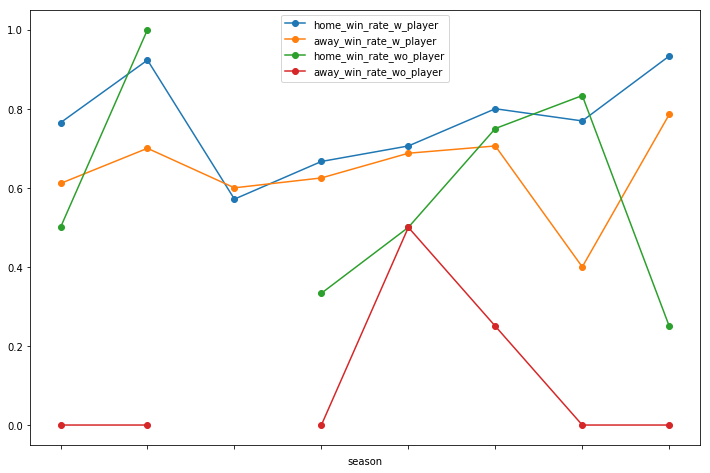

In [25]:
%%capture --no-display

seasons_of_zlatan.plot(y=['home_win_rate_w_player','away_win_rate_w_player','home_win_rate_wo_player','away_win_rate_wo_player' ], x='season', figsize=(12,8),marker='o')

Looking to this plot we can clearly see Zlatan is quite important player and when he plays the win rates are generally better. Especially in all the seasons teams with Zlatan won with higher rates in away games.

### Research Question 2  Do the teams of Zlatan win more games when he plays compared to the matches they play without him?

This time we are looking at the goal scored. Since Zlatan is a very good goal scorer we are expecting his teams to score more goals while he is in the game.

Similar to the first question I will create function to make the analysis easies

In [26]:
#  This function analyzes goal rates of a team with the player that we are
#  checking and it returns a result dataframe


def analyze_goals_of_a_player(season, player_id, team_id):
    
    result = pd.DataFrame(columns=['season','home_matches_w_player', 'home_goals_w_player', 'home_goal_rate_w_player', \
                                  'home_matches_wo_player', 'home_goals_wo_player', 'home_goal_rate_wo_player',\
                                  'away_matches_w_player', 'away_goals_w_player', 'away_goal_rate_w_player',\
                                  'away_matches_wo_player', 'away_goals_wo_player', 'away_goal_rate_wo_player'])
    
    # matches of the player
    home_games = find_all_home_games_of_a_player(player_id)
    home_games_season = home_games[home_games.season == season]
    home_games_team = find_team_season(team_id, season, True)

    home_game_count_player = home_games_season.id.count()
    home_game_goal_count_player = home_games_season.home_team_goal.sum()
    home_game_goal_rate_player = home_game_goal_count_player / home_game_count_player
    home_game_count_team = home_games_team.id.count()
    home_game_goal_count_team = home_games_team.home_team_goal.sum()
    home_game_win_rate_team = home_game_goal_count_team / home_game_count_team
   
    df = pd.merge(home_games_team, home_games_season, how='outer', indicator=True)
    rows_in_df1_not_in_df2 = df[df['_merge']=='left_only'][home_games_team.columns]
    home_game_count_wo_player = rows_in_df1_not_in_df2.id.count()
    home_game_goal_count_wo_player = rows_in_df1_not_in_df2.home_team_goal.sum()
    home_game_goal_rate_wo_player = home_game_goal_count_wo_player / home_game_count_wo_player
    
    
    away_games = find_all_away_games_of_a_player(player_id)
    away_games_season = away_games[away_games.season == season]
    away_games_team = find_team_season(team_id, season, False)
    
    away_game_count_player = away_games_season.id.count()
    away_game_goal_count_player = away_games_season.away_team_goal.sum()
    away_game_goal_rate_player = away_game_goal_count_player / away_game_count_player
    away_game_count_team = away_games_team.id.count()
    away_game_goal_count_team = away_games_team.away_team_goal.sum()
    away_game_goal_rate_team = away_game_goal_count_team / away_game_count_team

    df = pd.merge(home_games_team, home_games_season, how='outer', indicator=True)
    rows_in_df1_not_in_df2 = df[df['_merge']=='left_only'][home_games_team.columns]

    away_game_count_wo_player = rows_in_df1_not_in_df2.id.count()
    away_game_goal_count_wo_player = rows_in_df1_not_in_df2.away_team_goal.sum()
    away_game_goal_rate_wo_player = away_game_goal_count_wo_player / away_game_count_wo_player
   
    
    result.loc[0] = [season, home_game_count_player, home_game_goal_count_player, \
                    home_game_goal_rate_player, home_game_count_wo_player, \
                    home_game_goal_count_wo_player, home_game_goal_rate_wo_player, \
                    away_game_count_player, away_game_goal_count_player, \
                    away_game_goal_rate_player, away_game_count_wo_player, \
                    away_game_goal_count_wo_player, away_game_goal_rate_wo_player, \
                    ]
    return result


In [27]:
goals_of_zlatan = pd.DataFrame()
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2008/2009', 35724, 8636))
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2009/2010', 35724, 8634))
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2010/2011', 35724, 8664))
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2011/2012', 35724, 8564))
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2012/2013', 35724, 9847))
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2013/2014', 35724, 9847))
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2014/2015', 35724, 9847))
goals_of_zlatan = goals_of_zlatan.append(analyze_goals_of_a_player('2015/2016', 35724, 9847))

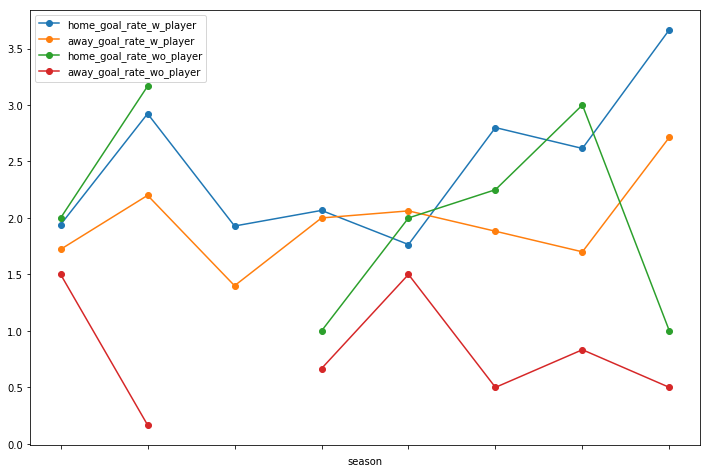

In [28]:
%%capture --no-display

goals_of_zlatan.plot(y=['home_goal_rate_w_player','away_goal_rate_w_player','home_goal_rate_wo_player','away_goal_rate_wo_player' ], x='season', figsize=(12,8),marker='o')

Looking at this plot, we also conclude Zlatan is quite valuable asset for the teams having him. In all the seasons the teams scored with a better rate in away games. And only in 2 seasons teams that dont have Zlatan playing scored with a better rate and else in all other season they did better with Zlatan playing. And more importantly teams with zlatan in their home ground score around 2 goals per games which is a remarkable number.

<a id='conclusions'></a>
## Conclusions

In this assignment I have done a data analysis to see how Zlatan Ibrahimovic performed in the teams he played for 8 years. I had two research questions, the first one is about how teams having Zlatan Ibrahimovic in their lineup affects their win rates and the second one is similarly how having him in your squad changes your goal ratio per game.

After the analysis we observed Zlatan is quite important for the teams he played, and when he plays the teams he is in scores more and wins more.

## References:

I used two sources for major difficulties I faced. 

The first one was to have a SQL database into a dataframe
https://www.dataquest.io/blog/python-pandas-databases/

Second one was for checking two dataframes to see the differences
https://stackoverflow.com/questions/33349797/compare-pandas-dataframes-and-return-rows-that-are-missing-from-the-first-one
